# 03 - Extracting forcing data

## Extracting meteorological data for a selected watershed
Using a GeoJSON file extracted from the HydroSHEDS database or given by the user, meteorological datasets can be extracted inside the watershed's boundaries using the PAVICS-Hydro ERA5 database.

In [1]:
# Boilerplate packages required. Do not modify!
import datetime as dt
import xarray as xr
import s3fs
import fsspec
import intake
from clisops.core import subset

If we want to extract data for our watershed, we need to know:

- The spatial extent (as defined by the watershed boundaries);
- The temporal extent (as defined by the start and end days of the period of interest).

Let's define those now:

In [2]:
# This will be our input section, where we control what we want to extract. 
# We know which watershed interests us, it is the input.geojson file that we previously generated!

basin_contour = 'input.geojson' # Can be generated using notebook "04_Delineating watersheds"

# Also, we can specify which timeframe we want to extract. Here let's focus on a 10-year period
reference_start_day = dt.datetime(1980, 12, 31)
reference_stop_day = dt.datetime(1991, 1, 1) 
# Notice we are using one day before and one day after the desired period of 1981-01-01 to 1990-12-31.
# This is to account for any UTC shifts that might require getting data in a previous or later time.


We now provide a means to get some data to run our model. Typically, models wil require precipitation and temperature data, so let's get that data. We will use a generally reliable dataset that is available everywhere to minimize missing values: the ERA5 Reanalysis. 

The code block below gathers the required data automatically. If you need other data or want to use another source, this cell will need to be replaced for your customized needs.

In [3]:
# Get the ERA5 data from the Wasabi/Amazon S3 server. Will eventually be replaced by the more efficient direct call with auto-updating timesteps.
# Future code:
'''
catalog_name = 'https://raw.githubusercontent.com/hydrocloudservices/catalogs/main/catalogs/atmosphere.yaml'
cat=intake.open_catalog(catalog_name)
ds=cat.era5_hourly_reanalysis_single_levels_ts.to_dask()
'''

# For now, let's use this method:
''' 
Configuration keys. Boilerplate, should not be changed.
'''
CLIENT_KWARGS = {'endpoint_url': 'https://s3.wasabisys.com','region_name': 'us-east-1'}
CONFIG_KWARGS = {'max_pool_connections': 100}
STORAGE_OPTIONS = {'anon': True,'client_kwargs': CLIENT_KWARGS,'config_kwargs': CONFIG_KWARGS}

'''
Prepare the filesystem and mapper that points to the data itself on the AmazonS3 directory
'''
fsERA5 = fsspec.filesystem('s3', **STORAGE_OPTIONS)
mapper = fsERA5.get_mapper('s3://era5/world/reanalysis/single-levels/zarr-temporal/2021-06-30')

'''
Get the ERA5 data. We will rechunk it to a single chunck to make it compatible with other codes on the platform, especially bias-correction.
We are also taking the daily min and max temperatures as well as the daily total precipitation.
'''
# We will add a wrapper to ensure that the following operations will preserve the original data attributes, such as units and variable names.
with xr.set_options(keep_attrs=True):
    
    ERA5_reference=subset.subset_shape(xr.open_zarr(mapper, consolidated=True).sel(time=slice(reference_start_day,reference_stop_day)), basin_contour)
    ERA5_tmin=ERA5_reference['t2m'].resample(time='1D').min().chunk(-1,-1,-1)
    ERA5_tmax=ERA5_reference['t2m'].resample(time='1D').max().chunk(-1,-1,-1)
    ERA5_pr=ERA5_reference['tp'].resample(time='1D').sum().chunk(-1,-1,-1)


### We can now convert these variables to the desired format and save them to disk in netcdf files to use at a later time (in a future notebook!)

First, we will want to make sure that the units we are working with are compatible with the Raven modelling framework. We will want precipitation to be in mm (per time period, here we are working daily so it will be in mm/day), and temperatures will be in °C. Let's check out the current units:

In [4]:
print('INFORMATION FOR TMIN')
print(ERA5_tmin)
print("")
print('INFORMATION FOR TMAX')
print(ERA5_tmax)
print("")
print('INFORMATION FOR PRECIPITATION')
print(ERA5_pr)
print("")

INFORMATION FOR TMIN
<xarray.DataArray 't2m' (time: 3654, latitude: 20, longitude: 16)>
dask.array<rechunk-merge, shape=(3654, 20, 16), dtype=float32, chunksize=(3654, 20, 16), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1980-12-31 1981-01-01 ... 1991-01-01
  * latitude   (latitude) float64 52.25 52.0 51.75 51.5 ... 48.0 47.75 47.5
  * longitude  (longitude) float32 -74.25 -74.0 -73.75 ... -71.0 -70.75 -70.5
Attributes:
    long_name:     2 metre temperature
    units:         K
    grid_mapping:  crs

INFORMATION FOR TMAX
<xarray.DataArray 't2m' (time: 3654, latitude: 20, longitude: 16)>
dask.array<rechunk-merge, shape=(3654, 20, 16), dtype=float32, chunksize=(3654, 20, 16), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1980-12-31 1981-01-01 ... 1991-01-01
  * latitude   (latitude) float64 52.25 52.0 51.75 51.5 ... 48.0 47.75 47.5
  * longitude  (longitude) float32 -74.25 -74.0 -73.75 ... -71.0 -70.75 -70.5
Attributes:
    lo

We can see that the units are in Kelvin for temperatures and in meters for precipitation. We will want to do some conversions!

Let's start by applying offsets for temperatures and a conversion factor for precipitation:


In [5]:
with xr.set_options(keep_attrs=True):
    ERA5_tmin = ERA5_tmin - 273.15 # K to °C
    ERA5_tmin.attrs['units'] = 'degC'

    ERA5_tmax = ERA5_tmax - 273.15 # K to °C
    ERA5_tmax.attrs['units'] = 'degC'

    ERA5_pr = ERA5_pr * 1000 # m to mm
    ERA5_pr.attrs['units'] = 'mm'

We can see the changes now by re-inspecting the datasets:

In [6]:
print('INFORMATION FOR TMIN')
print(ERA5_tmin)
print("")
print('INFORMATION FOR TMAX')
print(ERA5_tmax)
print("")
print('INFORMATION FOR PRECIPITATION')
print(ERA5_pr)
print("")

INFORMATION FOR TMIN
<xarray.DataArray 't2m' (time: 3654, latitude: 20, longitude: 16)>
dask.array<sub, shape=(3654, 20, 16), dtype=float32, chunksize=(3654, 20, 16), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1980-12-31 1981-01-01 ... 1991-01-01
  * latitude   (latitude) float64 52.25 52.0 51.75 51.5 ... 48.0 47.75 47.5
  * longitude  (longitude) float32 -74.25 -74.0 -73.75 ... -71.0 -70.75 -70.5
Attributes:
    long_name:     2 metre temperature
    units:         degC
    grid_mapping:  crs

INFORMATION FOR TMAX
<xarray.DataArray 't2m' (time: 3654, latitude: 20, longitude: 16)>
dask.array<sub, shape=(3654, 20, 16), dtype=float32, chunksize=(3654, 20, 16), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1980-12-31 1981-01-01 ... 1991-01-01
  * latitude   (latitude) float64 52.25 52.0 51.75 51.5 ... 48.0 47.75 47.5
  * longitude  (longitude) float32 -74.25 -74.0 -73.75 ... -71.0 -70.75 -70.5
Attributes:
    long_name:     2 me

So let's write them to disk for now. We will use the netcdf format as this is what Raven uses for inputs. It is possible you will get some warnings, this is OK and should not cause any problems. Since our model will run in lumped mode, we will average the spatial dimensions of each variable over the domain.

In [7]:
with xr.set_options(keep_attrs=True):
    # Average the variables
    ERA5_tmin = ERA5_tmin.mean({'latitude','longitude'})
    ERA5_tmax = ERA5_tmax.mean({'latitude','longitude'})
    ERA5_pr = ERA5_pr.mean({'latitude','longitude'})
    
    # Ensure that the precipitation is non-negative, which can happen with some reanalysis models.
    ERA5_pr[ERA5_pr < 0] = 0
 
    # Transform them to a dataset such that they can be written with attributes to netcdf
    ERA5_tmin = ERA5_tmin.to_dataset(name='tmin',promote_attrs=True)
    ERA5_tmax = ERA5_tmax.to_dataset(name='tmax',promote_attrs=True)
    ERA5_pr = ERA5_pr.to_dataset(name='pr',promote_attrs=True)  


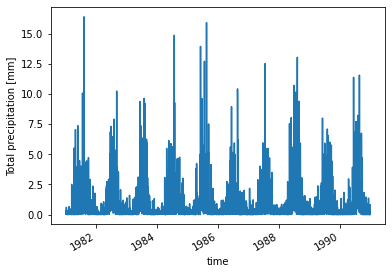

In [8]:
ERA5_pr.pr.plot()

In [9]:
with xr.set_options(keep_attrs=True):
    # Write to disk.
    ERA5_tmin.to_netcdf('ERA5_tmin.nc')
    ERA5_tmax.to_netcdf('ERA5_tmax.nc')
    ERA5_pr.to_netcdf('ERA5_pr.nc')

/opt/conda/envs/birdy/lib/python3.8/site-packages/dask/array/reductions.py:538: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/opt/conda/envs/birdy/lib/python3.8/site-packages/dask/array/reductions.py:567: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


We now have daily precipitation and minimum/maximum temperatures to drive our Raven Model, which we will do in the next notebook!